# swin

> Swin Transformer V2 Encoder for midi-rae — drop-in replacement for ViTEncoder

In [ ]:
#| default_exp swin

In [ ]:
#| hide
from nbdev.showdoc import *

## Design Overview

### Motivation: Multi-Scale Understanding

We're not doing mere image segmentation. The representations at different scales may be very different from one another and mapped non-linearly. Consider: the top-level representation could be something about musical genre. The next level down could be something about what part of the song we're in. The next level down could be which part of the verse or chorus we're in. The next level could be a given musical phrase. The next level could be the individual notes in the phrase.

### Same Info, Organized Differently

**ViT:** The default ViT we've been using has 65 patches with 256 dimensions each: 65 * 256 = **16,640 encoding parameters**.

For the a Swin with 6 stages, `embed_dim=8`, `patch_h=patch_w=4`, so the finest grid is 32×32:

| Level | Patch Size (px) | Grid | Dim | Scalars |
|-------|-----------------|------|-----|---------|
| 0 (coarsest) | 128x128 | 1×1 | 256 | 256 |
| 1 | 64x64 | 2×2  | 128 | 512 |
| 2 | 32x32 | 4×4 |  64 | 1,024 |
| 3 | 16x16 | 8×8 | 32 | 2,048 |
| 4 |  8x8  | 16×16 | 16 | 4,096 |
| 5 (finest) | 4x4   | 32x32 | 8 | 8,192 |
| **Total** | | | **16,128 encoding parameters** |

...So the Swin has basically the same amount of information as the ViT (actually slightly less!), it's just organized differently.



### What this module does

`SwinEncoder` is a drop-in replacement for `ViTEncoder` that uses the **Swin Transformer V2**
architecture. It takes a piano roll image `(B, 1, 128, 128)` and returns an `EncoderOutput`
with hierarchical multi-scale patch states.

### Why Swin V2?

- **Hierarchical representation**: 7 levels from finest (64×64 grid, dim=4) down to a single
  CLS-like token (1×1, dim=256), compared to ViT's flat single-scale output
- **Efficient attention**: Windowed attention with shifted windows — O(N) instead of O(N²)
- **V2 improvements**: Cosine attention with learned log-scale temperature, continuous position
  bias via CPB MLP, res-post-norm for training stability

### Architecture

| Stage | Grid | Patch covers | Dim | Depths | Heads |
|-------|------|-------------|-----|--------|-------|
| 0 | 64×64 | 2×2 | 4 | 1 | 1 |
| 1 | 32×32 | 4×4 | 8 | 1 | 1 |
| 2 | 16×16 | 8×8 | 16 | 2 | 1 |
| 3 | 8×8 | 16×16 | 32 | 2 | 2 |
| 4 | 4×4 | 32×32 | 64 | 6 | 4 |
| 5 | 2×2 | 64×64 | 128 | 2 | 8 |
| 6 | 1×1 | 128×128 | 256 | 1 | 16 |

Config is in `configs/config_swin.yaml`.

### Implementation approach

We use **timm's `SwinTransformerV2Stage` directly** — no copied or modified Swin internals.
Our `SwinEncoder` wrapper handles only:

1. **Patch embedding** — `Conv2d(1, 4, kernel_size=2, stride=2)` + LayerNorm
2. **Empty patch detection** — patches where all pixels are black get a learnable `empty_token`
3. **MAE masking** (SimMIM-style) — masked patches get a learnable `mask_token`, grid stays
   intact so windowed attention works unmodified. Two-rate sampling: non-empty patches masked
   at `mask_ratio`, empty patches at `mask_ratio × empty_mask_ratio` (default 5%)
4. **Hierarchical output** — collects each stage's output into `HierarchicalPatchState`
   (coarsest-first), packaged as `EncoderOutput`

### Key differences from ViTEncoder

- No CLS token (stage 6's single 1×1 token serves as a global summary)
- No RoPE (Swin V2 uses its own continuous position bias)
- MAE masking keeps all tokens (SimMIM-style) — no compute savings but preserves spatial grid
- `empty_mask_ratio` controls how often trivial-to-reconstruct empty patches are masked

### TODOs

- `HierarchicalPatchState` could store `window_size` per level
- `EncoderOutput` could store scale metadata (downsample factors per level)


### Future: advanced masking & representation learning

- **Inter-stage patch masking**: dropout-style masking between encoder stages, tapered
  ratio per stage (`mae_ratio / 2**stage_idx`), using a learnable mask token. Forces
  robust representations at every scale.
- **Self-distillation** (DINO/iBOT-style): EMA teacher provides latent targets at all
  scales, eliminating need for pixel-level reconstruction at coarser levels.
- **Multi-scale reconstruction losses**: reconstruct downsampled piano rolls at each
  hierarchy level (requires bidirectional decoder, e.g. U-Net with skip connections).


In [ ]:
#| export
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple, Set, Type, Union
from functools import partial

from timm.models.swin_transformer_v2 import SwinTransformerV2Stage
from timm.layers import trunc_normal_, to_2tuple, calculate_drop_path_rates
from midi_rae.core import PatchState, HierarchicalPatchState, EncoderOutput
from midi_rae.vit import TransformerBlock

In [ ]:
#| export
class SwinEncoder(nn.Module):
    "Swin Transformer V2 Encoder for midi-rae — drop-in replacement for ViTEncoder.  (Wrapper for timm routines)"
    def __init__(self,
                 img_height:int,           # Input image height in pixels (e.g. 128)
                 img_width:int,            # Input image width in pixels (e.g. 128)
                 patch_h:int=2,            # Patch height for initial embedding
                 patch_w:int=2,            # Patch width for initial embedding
                 in_chans:int=1,           # Number of input channels (1 for piano roll)
                 embed_dim:int=4,          # Base embedding dimension (doubles each stage)
                 depths:tuple=(1,1,2,2,6,2,1),   # Number of transformer blocks per stage
                 num_heads:tuple=(1,1,1,2,4,8,16),# Attention heads per stage
                 window_size:int=8,        # Window size for windowed attention
                 mlp_ratio:float=4.,       # MLP hidden dim = embed_dim * mlp_ratio
                 qkv_bias:bool=True,       # Add bias to QKV projections
                 drop_rate:float=0.,       # Dropout after patch embedding
                 proj_drop_rate:float=0.,  # Dropout after attention projection
                 attn_drop_rate:float=0.,  # Dropout on attention weights
                 drop_path_rate:float=0.1, # Stochastic depth rate
                 norm_layer:type=nn.LayerNorm, # Normalization layer class
                 mae_ratio:float=0.,       # Fraction of non-empty patches to mask (0=no masking)
                 empty_mask_ratio:float=0.05): # Mask rate for empty patches relative to mae_ratio
        super().__init__()
        self.num_stages, self.embed_dim = len(depths), embed_dim
        self.num_features = int(embed_dim * 2 ** (self.num_stages - 1))
        self.patch_h, self.patch_w, self.grid_size = patch_h, patch_w,  (img_height // patch_h, img_width // patch_w)
        self.mae_ratio, self.empty_mask_ratio = mae_ratio, empty_mask_ratio

        # Patch embedding
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w))
        self.patch_norm = norm_layer(embed_dim)
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Learnable replacement tokens
        self.empty_token, self.mask_token = nn.Parameter(torch.zeros(embed_dim)), nn.Parameter(torch.zeros(embed_dim))

        # Build stages using timm's SwinTransformerV2Stage
        embed_dims = [int(embed_dim * 2 ** i) for i in range(self.num_stages)]
        dpr = calculate_drop_path_rates(drop_path_rate, list(depths), stagewise=True)
        self.stages = nn.ModuleList()
        in_dim, scale = embed_dims[0], 1
        for i in range(self.num_stages):
            out_dim = embed_dims[i]
            self.stages.append(SwinTransformerV2Stage(
                dim=in_dim, out_dim=out_dim, depth=depths[i], num_heads=num_heads[i],
                input_resolution=(self.grid_size[0] // scale, self.grid_size[1] // scale),
                window_size=window_size, downsample=(i > 0), mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, proj_drop=proj_drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer))
            in_dim = out_dim
            if i > 0: scale *= 2

        self.norm = norm_layer(self.num_features)
        self.apply(self._init_weights)
        for stage in self.stages: stage._init_respostnorm()

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None: nn.init.constant_(m.bias, 0)

    @torch.jit.ignore
    def no_weight_decay(self) -> Set[str]:
        nod = {'empty_token', 'mask_token'}
        for n, _ in self.named_parameters():
            if any(kw in n for kw in ('cpb_mlp', 'logit_scale')): nod.add(n)
        return nod

    def _compute_non_empty(self, img):
        "Detect which patches have content (non-black)."
        patches = img.unfold(2, self.patch_h, self.patch_h).unfold(3, self.patch_w, self.patch_w)
        return (patches.amax(dim=(-1, -2)) > 0.2).squeeze(1).flatten(1)  # (B, N)

    def _make_mae_mask(self, non_empty, device, effective_ratio=None):
        "Two-rate MAE mask: non-empty at mae_ratio, empty at mae_ratio*empty_mask_ratio. Returns (B,N) bool, True=visible."
        B, N = non_empty.shape
        rand = torch.rand(B, N, device=device)
        ratio = effective_ratio if effective_ratio is not None else self.mae_ratio
        threshold = torch.where(non_empty.bool(),
            torch.full_like(rand, 1.0 - ratio),
            torch.full_like(rand, 1.0 - ratio * self.empty_mask_ratio))
        return rand < threshold

    def _make_grid_pos(self, h, w, device):
        "Build (h*w, 2) grid positions."
        return torch.stack(torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij'), dim=-1).reshape(-1, 2)

    def forward(self, x, mask_ratio:float=0., mae_mask:Optional[torch.Tensor]=None) -> EncoderOutput:
        "x: (B,C,H,W) piano roll. mask_ratio overrides self.mae_ratio. mae_mask: (N,) bool, True=visible."
        B, device = x.shape[0], x.device
        grid_h, grid_w = self.grid_size
        N_full = grid_h * grid_w

        non_empty = self._compute_non_empty(x)                              # (B, N_full)
        x = self.patch_embed(x)                                             # (B, C, H', W')
        x = self.patch_norm(x.permute(0, 2, 3, 1).contiguous())            # → (B, H', W', C) NHWC
        B, H, W, C = x.shape

        # Replace empty patches with learned empty_token
        ne4d = non_empty.view(B, H, W, 1)
        x = torch.where(ne4d, x, self.empty_token.view(1, 1, 1, -1).expand_as(x))

        # MAE masking: replace masked positions with learned mask_token
        effective_ratio = mask_ratio if mask_ratio > 0 else self.mae_ratio
        if mae_mask is None and effective_ratio > 0:
            mae_mask = self._make_mae_mask(non_empty, device, effective_ratio)
        if mae_mask is not None:
            m4d = mae_mask.view(B, H, W, 1)
            x = torch.where(m4d, x, self.mask_token.view(1, 1, 1, -1).expand_as(x))
        else:
            mae_mask = torch.ones(B, N_full, device=device, dtype=torch.bool)
        x = self.pos_drop(x)

        # Run stages, collect intermediates
        intermediates = []
        for i, stage in enumerate(self.stages):
            x = stage.downsample(x) if i == len(self.stages) - 1 else stage(x) # no attention on coursest (solo) level
            intermediates.append(x)
        intermediates[-1] = self.norm(intermediates[-1])

        # Build non-empty masks for each scale via max-pool cascade
        ne = non_empty.view(B, 1, grid_h, grid_w).float()
        ne_scales = []
        for feat in intermediates:
            Hf, Wf = feat.shape[1], feat.shape[2]
            while ne.shape[2] > Hf:
                ne = F.max_pool2d(ne, 2)
            ne_scales.append(ne.view(B, -1))

        # Build HierarchicalPatchState (coarsest first)
        levels = []
        for feat, ne_s in zip(reversed(intermediates), reversed(ne_scales)):
            Bf, Hf, Wf, Cf = feat.shape
            n = Hf * Wf
            levels.append(PatchState(
                emb=feat.reshape(Bf, n, Cf), pos=self._make_grid_pos(Hf, Wf, device),
                non_empty=ne_s,
                mae_mask=torch.ones(n, device=device, dtype=torch.bool)))

        return EncoderOutput(patches=HierarchicalPatchState(levels=levels),
            full_pos=self._make_grid_pos(grid_h, grid_w, device),
            full_non_empty=non_empty, mae_mask=mae_mask)

In [ ]:
#| eval: false
# Test: verify SwinEncoder output shapes
B, C, H, W = 2, 1, 128, 128
enc = SwinEncoder(img_height=H, img_width=W)
x = torch.randn(B, C, H, W)
out = enc(x)

print(f'mae_mask:        {out.mae_mask.shape}')
print(f'full_pos:        {out.full_pos.shape}')
print(f'full_non_empty:  {out.full_non_empty.shape}')
print(f'num levels:      {len(out.patches.levels)}')
for i, ps in enumerate(out.patches.levels):
    g = int(ps.pos.shape[0]**0.5)
    p = H // g
    print(f'  level {i}: emb={ps.emb.shape}, pos={ps.pos.shape}  — grid {g}×{g} ({p}×{p} patch{"es" if ps.emb.shape[1]>1 else ""})')

# Expected hierarchy (coarsest first), 128×128 image, 2×2 patches:
#   level 0 (coarsest): emb=(1, 1,    256) — grid 1×1  (CLS-like)
#   level 1:            emb=(1, 4,    128) — grid 2×2
#   level 2:            emb=(1, 16,    64) — grid 4×4
#   level 3:            emb=(1, 64,    32) — grid 8×8
#   level 4:            emb=(1, 256,   16) — grid 16×16
#   level 5:            emb=(1, 1024,   8) — grid 32×32
#   level 6 (finest):   emb=(1, 4096,   4) — grid 64×64

mae_mask:        torch.Size([2, 4096])
full_pos:        torch.Size([4096, 2])
full_non_empty:  torch.Size([2, 4096])
num levels:      7
  level 0: emb=torch.Size([2, 1, 256]), pos=torch.Size([1, 2])  — grid 1×1 (128×128 patch)
  level 1: emb=torch.Size([2, 4, 128]), pos=torch.Size([4, 2])  — grid 2×2 (64×64 patches)
  level 2: emb=torch.Size([2, 16, 64]), pos=torch.Size([16, 2])  — grid 4×4 (32×32 patches)
  level 3: emb=torch.Size([2, 64, 32]), pos=torch.Size([64, 2])  — grid 8×8 (16×16 patches)
  level 4: emb=torch.Size([2, 256, 16]), pos=torch.Size([256, 2])  — grid 16×16 (8×8 patches)
  level 5: emb=torch.Size([2, 1024, 8]), pos=torch.Size([1024, 2])  — grid 32×32 (4×4 patches)
  level 6: emb=torch.Size([2, 4096, 4]), pos=torch.Size([4096, 2])  — grid 64×64 (2×2 patches)


Testing code to check for non-empty patches: Green equals non-empty, red equals empty

Loading 273 val files from ~/datasets/POP909_images/...
Finished loading.


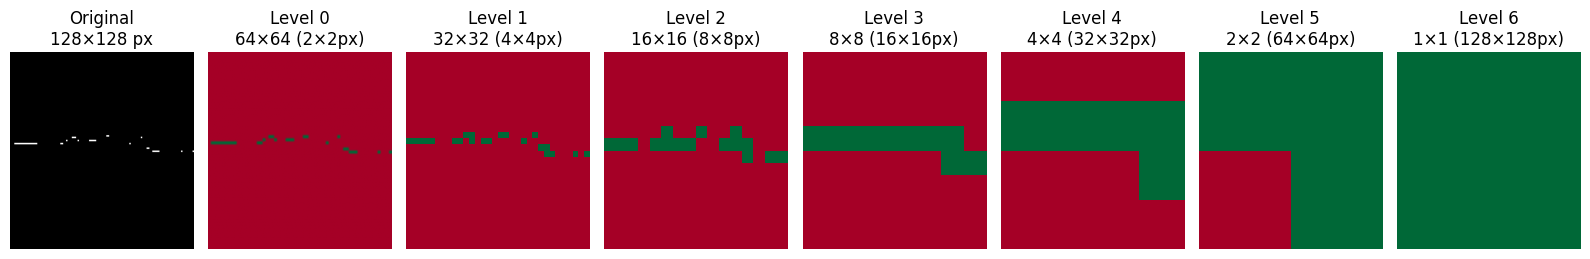

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
import torch.nn.functional as F
from midi_rae.data import PRPairDataset

# Load one image from the dataset
ds = PRPairDataset(split='val')
img_tensor = ds[0]['img1'][:1]
x = img_tensor.unsqueeze(0)

# Run empty patch detection
enc = SwinEncoder(img_height=128, img_width=128)
non_empty = enc._compute_non_empty(x)
ne = non_empty[0].reshape(1, 1, 64, 64).float()

# Build hierarchy via max-pool cascade
levels = [ne[0, 0].cpu()]  # 64×64
while levels[-1].shape[0] > 1:
    ne = F.max_pool2d(ne, 2)
    levels.append(ne[0, 0].cpu())

# Plot: original image + all levels
fig, axes = plt.subplots(1, len(levels) + 1, figsize=(16, 2.7))
axes[0].imshow(img_tensor[0].cpu(), cmap='gray', origin='lower', aspect='auto')
axes[0].set_title('Original\n128×128 px')
for i, grid in enumerate(levels):
    g = grid.shape[0]
    axes[i+1].imshow(grid.numpy(), cmap='RdYlGn', origin='lower', aspect='auto', vmin=0, vmax=1)
    p = 128 // g
    axes[i+1].set_title(f'Level {i}\n{g}×{g} ({p}×{p}px)')
    axes[i+1].axis('off')
axes[0].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#| export
class PixelShuffleHead(nn.Module):
    def __init__(self, out_channels=1, fpn_dim=64, hidden_ch=64, patch_size=4, grid_h=32, grid_w=32):
        super().__init__()
        self.fpn_dim, self.patch_size, self.grid_h, self.grid_w = fpn_dim, patch_size, grid_h, grid_w
        ps_r = 2 # pixel shuffle ratio
        self.layers= nn.Sequential(
                nn.Conv2d(fpn_dim, hidden_ch, kernel_size=3, padding=1), 
                nn.GELU(),
                nn.PixelShuffle(ps_r), 
                nn.Conv2d(hidden_ch//(ps_r**2), (ps_r**2)*out_channels, kernel_size=3, padding=1), 
                nn.PixelShuffle(ps_r)
                )      
    def forward(self, z): 
        B, N, f = z.shape
        z = z.reshape((B, f, self.grid_h, self.grid_w))
        return self.layers(z) 

In [ ]:
#| export
class SwinMAEDecoder(nn.Module):
    """FPN-style MAE decoder for SwinEncoder hierarchical output.
    Top-down pathway fuses all levels, reconstructs at finest scale."""
    def __init__(self, patch_size=4, dims=(256, 128, 64, 32, 16, 8),
                 fpn_dim=64, depth=2, heads=4):
        super().__init__()
        self.patch_size = patch_size
        self.laterals = nn.ModuleList([nn.Linear(d, fpn_dim) for d in dims]) # Per-level lateral projections to common fpn_dim
        self.mask_token = nn.Parameter(torch.randn(1, 1, fpn_dim))         # Mask token at finest level
        # Light transformer refinement after fusion
        self.blocks = nn.ModuleList([TransformerBlock(fpn_dim, heads) for _ in range(depth)])
        self.proj = nn.Linear(fpn_dim, patch_size * patch_size)          # Reconstruct pixels
        #self.proj = PixelShuffleHead(fpn_dim=fpn_dim)
        
    def forward(self, enc_out):
        """levels: list of PatchState (coarsest-first), mae_mask: (B,N_finest) bool"""
        levels = enc_out.patches.levels  # list of PatchState, coarsest-first
        mae_mask = enc_out.mae_mask      # (B, N_finest)
        feats = [lat(lv.emb) for lat, lv in zip(self.laterals, levels)]    # Lateral projections
        # Top-down: upsample coarse and add to next finer
        for i in range(1, len(feats)):
            B, N_coarse, C = feats[i-1].shape
            B, N_fine, C = feats[i].shape
            scale = int((N_fine / N_coarse) ** 0.5)
            g_c = int(N_coarse ** 0.5)
            up = feats[i-1].view(B, g_c, g_c, C).permute(0,3,1,2)
            up = F.interpolate(up, scale_factor=scale, mode='nearest')
            feats[i] = feats[i] + up.permute(0,2,3,1).reshape(B, N_fine, C)
        # Finest level with mask tokens
        z = feats[-1]  # (B, N_finest, fpn_dim)
        z_full = self.mask_token.expand_as(z).clone()
        z_full[mae_mask] = z[mae_mask]
        for block in self.blocks:
            z_full = block(z_full, pos=levels[-1].pos)
        return self.proj(z_full)
        #img = self.proj(z_full)                                          # (B, 1, H, W)
        #return img.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).reshape(B, -1, self.patch_size**2)

In [ ]:
#| export
class PatchExpand(nn.Module):
    """Inverse of patch merging: doubles spatial resolution via learned linear expansion.
    (B, H, W, C_in) → (B, 2H, 2W, C_out)"""
    def __init__(self, in_dim, out_dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.expand = nn.Linear(in_dim, 4 * out_dim, bias=False)
        self.norm = norm_layer(out_dim)

    def forward(self, x):
        B, H, W, C = x.shape
        x = self.expand(x)                                              # (B, H, W, 4*C_out)
        x = x.view(B, H, W, 2, 2, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).reshape(B, 2*H, 2*W, -1)     # (B, 2H, 2W, C_out)
        return self.norm(x)


class SwinDecoder(nn.Module):
    """Swin V2 Decoder for midi-rae — symmetric multi-stage decoder.

    Mirrors the encoder architecture: processes coarsest→finest with Swin V2
    windowed attention at every spatial scale, fusing encoder skip connections
    via lateral projections at each level.

    Pass the same config values (embed_dim, depths, num_heads) as the encoder;
    they are reversed internally for the coarsest→finest decode direction.

    Takes EncoderOutput directly (same interface as SwinMAEDecoder).

    TODO: Try ConvTranspose2d or PixelShuffle as alternatives to linear unpatchify.
    TODO: Make the unpatchify head swappable via a factory or argument.
    """
    def __init__(self,
                 img_height:int=128,           # Output image height
                 img_width:int=128,            # Output image width
                 patch_h:int=4,                # Patch height (must match encoder)
                 patch_w:int=4,                # Patch width (must match encoder)
                 out_channels:int=1,           # Output channels (1 for piano roll)
                 embed_dim:int=8,              # Base embedding dim (same as encoder)
                 depths:tuple=(1,2,2,6,2,1),   # Encoder depths (finest→coarsest); reversed internally
                 num_heads:tuple=(1,1,2,4,8,16), # Encoder heads (finest→coarsest); reversed internally
                 window_size:int=8,            # Window size for windowed attention
                 mlp_ratio:float=4.,           # MLP hidden dim = dim * mlp_ratio
                 qkv_bias:bool=True,           # Bias in QKV projections
                 drop_path_rate:float=0.1,     # Stochastic depth rate
                 proj_drop_rate:float=0.,      # Dropout after attention projection
                 attn_drop_rate:float=0.,      # Dropout on attention weights
                 norm_layer:type=nn.LayerNorm):
        super().__init__()
        self.patch_h, self.patch_w, self.out_channels = patch_h, patch_w, out_channels
        num_stages = len(depths)

        # Decoder processes coarsest→finest (reverse of encoder)
        dec_dims = [int(embed_dim * 2**(num_stages - 1 - i)) for i in range(num_stages)]
        dec_depths = list(reversed(depths))
        dec_heads = list(reversed(num_heads))

        # Grid sizes at each decoder stage (coarsest→finest)
        finest_h, finest_w = img_height // patch_h, img_width // patch_w
        grids = [(finest_h // 2**(num_stages - 1 - i),
                  finest_w // 2**(num_stages - 1 - i)) for i in range(num_stages)]
        self.finest_h, self.finest_w = finest_h, finest_w

        # Lateral projections: encoder → decoder space at each scale
        self.laterals = nn.ModuleList([nn.Linear(d, d) for d in dec_dims])

        # Swin V2 attention stages (None for 1×1 — can't self-attend a single token)
        self.stages = nn.ModuleList()
        dpr = calculate_drop_path_rates(drop_path_rate, dec_depths, stagewise=True)
        for i in range(num_stages):
            gh, gw = grids[i]
            if gh <= 1 and gw <= 1:
                self.stages.append(None)
            else:
                self.stages.append(SwinTransformerV2Stage(
                    dim=dec_dims[i], out_dim=dec_dims[i], depth=dec_depths[i],
                    num_heads=dec_heads[i], input_resolution=(gh, gw),
                    window_size=window_size, downsample=False, mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias, proj_drop=proj_drop_rate, attn_drop=attn_drop_rate,
                    drop_path=dpr[i], norm_layer=norm_layer))

        # Upsample between stages (inverse of patch merging)
        self.upsamples = nn.ModuleList([
            PatchExpand(dec_dims[i], dec_dims[i+1], norm_layer)
            for i in range(num_stages - 1)])

        # Final norm + linear unpatchify head
        self.norm = norm_layer(dec_dims[-1])
        self.head = nn.Linear(dec_dims[-1], out_channels * patch_h * patch_w)

        self.apply(self._init_weights)
        for stage in self.stages:
            if stage is not None: stage._init_respostnorm()

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None: nn.init.constant_(m.bias, 0)

    @torch.jit.ignore
    def no_weight_decay(self) -> Set[str]:
        nod = set()
        for n, _ in self.named_parameters():
            if any(kw in n for kw in ('cpb_mlp', 'logit_scale')): nod.add(n)
        return nod

    def forward(self, enc_out: EncoderOutput) -> torch.Tensor:
        "enc_out: EncoderOutput from SwinEncoder. Returns (B, out_channels, H, W)."
        levels = enc_out.patches.levels  # coarsest-first, matching decoder order
        B = levels[0].emb.shape[0]

        # Start from coarsest encoder features
        z = self.laterals[0](levels[0].emb)
        g = int(levels[0].pos.shape[0]**0.5)
        z = z.view(B, g, g, -1)
        if self.stages[0] is not None: z = self.stages[0](z)

        # Progressive decode: upsample → fuse encoder features → attend
        for i in range(len(self.upsamples)):
            z = self.upsamples[i](z)                              # (B, 2H, 2W, next_dim)
            lat = self.laterals[i+1](levels[i+1].emb)            # (B, N, dim)
            gh, gw = z.shape[1], z.shape[2]
            z = z + lat.view(B, gh, gw, -1)                      # fuse
            if self.stages[i+1] is not None: z = self.stages[i+1](z)

        z = self.norm(z)

        # Linear unpatchify → image
        z = z.reshape(B, -1, z.shape[-1])
        px = self.head(z)
        px = px.reshape(B, self.finest_h, self.finest_w,
                        self.patch_h, self.patch_w, self.out_channels)
        return px.permute(0, 5, 1, 3, 2, 4).reshape(
            B, self.out_channels,
            self.finest_h * self.patch_h, self.finest_w * self.patch_w)

Test: verify SwinDecoder output shapes:

In [ ]:
#| eval: false
B, C, H, W = 2, 1, 128, 128
depths, num_heads = (1,2,2,6,2,1), (1,1,2,4,8,16)
enc = SwinEncoder(img_height=H, img_width=W, patch_h=4, patch_w=4,
                  embed_dim=8, depths=depths, num_heads=num_heads)
dec = SwinDecoder(img_height=H, img_width=W, patch_h=4, patch_w=4,
                  embed_dim=8, depths=depths, num_heads=num_heads)

x = torch.randn(B, C, H, W)
enc_out = enc(x)
recon = dec(enc_out)

print(f'Input:  {x.shape}')
print(f'Output: {recon.shape}')
assert recon.shape == x.shape, f'Shape mismatch: {recon.shape} != {x.shape}'
print('✓ Shapes match!')

enc_params = sum(p.numel() for p in enc.parameters())
dec_params = sum(p.numel() for p in dec.parameters())
print(f'Encoder params: {enc_params:,}')
print(f'Decoder params: {dec_params:,}')

Input:  torch.Size([2, 1, 128, 128])
Output: torch.Size([2, 1, 128, 128])
✓ Shapes match!
Encoder params: 1,748,135
Decoder params: 1,035,735


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()